# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

['C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\paddle\\fluid\\..\\libs', 'C:/Users/cascara/AppData/Local/Programs/Python/Python37/Lib/site-packages/cv2\\python-3.7', 'c:\\Users\\cascara\\Desktop\\code\\2021spring\\gan\\cggan', 'c:\\Users\\cascara\\.vscode\\extensions\\ms-toolsai.jupyter-2021.5.745244803\\pythonFiles', 'c:\\Users\\cascara\\.vscode\\extensions\\ms-toolsai.jupyter-2021.5.745244803\\pythonFiles\\lib\\python', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\python37.zip', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\lib', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37', '', 'C:\\Users\\cascara\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages', 'C:\\Users\\cascara\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages

ImportError: ERROR: recursion is detected during loading of "cv2" binary extensions. Check OpenCV installation.

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [4]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


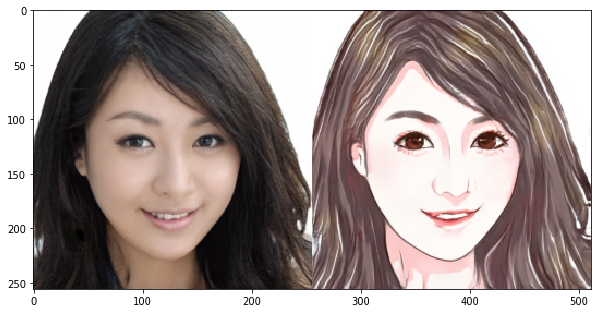

In [5]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 1, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()


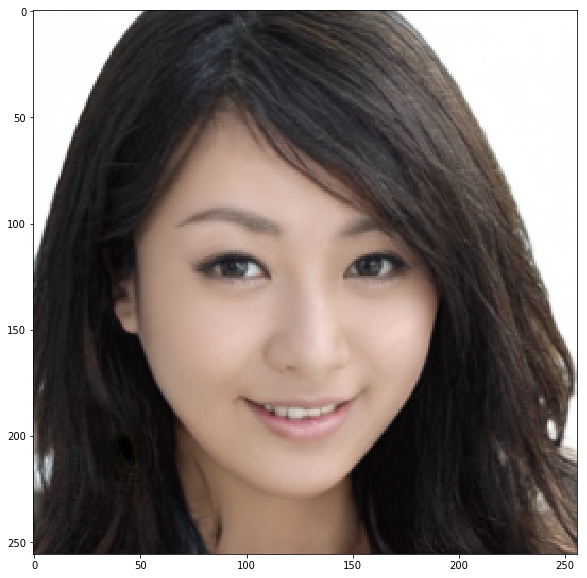

(3, 256, 256)
(256, 256, 3)


In [6]:

img_show = np.vstack(imgs)[:,:256,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

img=img_show.transpose((2,0,1))
print(img.shape)
print(img_show.shape)
# img_show = np.vstack(imgs)[:,:256,::-1]
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.show()

In [7]:
img_show = np.vstack(imgs)[:,:256,::-1]

img_show.shape

(256, 256, 3)

In [8]:
s=np.random.randint(0,255,[3,2])
print(s)
((s+1)/256)*2-1



[[127 201]
 [212   8]
 [150  76]]


array([[ 0.       ,  0.578125 ],
       [ 0.6640625, -0.9296875],
       [ 0.1796875, -0.3984375]])

In [9]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量
        print(self.img_path_list[:7])

    def __getitem__(self, idx):
        path=self.img_path_list[idx]
        img_A2B = cv2.imread(path)                                        # 读取一组数据
        img_A2B = ((img_A2B+1)/256)*2-1                                        # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose((2,0,1))                                    # 维度变换HWC -> CHW
        img_A = img_A2B[:,:,:256]                                          # 真人照
        img_B = img_A2B[:,:,256:]                                          # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [10]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

['data/cartoon_A2B/train/01271.png', 'data/cartoon_A2B/train/00712.png', 'data/cartoon_A2B/train/00403.png', 'data/cartoon_A2B/train/00485.png', 'data/cartoon_A2B/train/01319.png', 'data/cartoon_A2B/train/00688.png', 'data/cartoon_A2B/train/01146.png']
['data/cartoon_A2B/test/01474.png', 'data/cartoon_A2B/test/01475.png', 'data/cartoon_A2B/test/01486.png', 'data/cartoon_A2B/test/01449.png', 'data/cartoon_A2B/test/01492.png', 'data/cartoon_A2B/test/01512.png', 'data/cartoon_A2B/test/01462.png']


## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [11]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(

            nn.LeakyReLU(0.2),
            nn.Conv2D(in_dim, out_dim, kernel_size),
            nn.BatchNorm2D(out_dim)
                                # LeakyReLU, leaky=0.2
                                # Conv2D
                                # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),                    # ReLU
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size),                    # Conv2DTranspose
            nn.BatchNorm2D(out_dim)                    # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [12]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size),
            nn.BatchNorm2D(out_dim),
            nn.LeakyReLU(0.2)
                                # Conv2D
                                # BatchNorm2D
                                # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [13]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [32]:
print(discriminator)

NLayerDiscriminator(
  (layers): Sequential(
    (0): Conv2D(6, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvBlock(
      (layers): Sequential(
        (0): Conv2D(64, 128, kernel_size=[4, 4], data_format=NCHW)
        (1): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): ConvBlock(
      (layers): Sequential(
        (0): Conv2D(128, 256, kernel_size=[4, 4], data_format=NCHW)
        (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (4): ConvBlock(
      (layers): Sequential(
        (0): Conv2D(256, 512, kernel_size=[4, 4], data_format=NCHW)
        (1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (5): Conv2D(512, 1, kernel_size=[4, 4], padding=1, data_format=NCHW)
    (6): Sigmoid()
  )

In [33]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 118, 118]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [34]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = paddle.nn.BCELoss()
l1_loss = paddle.nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [41]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        data_A, data_B = data
        real_A=data_A.astype(np.float32)
        real_B=data_B.astype(np.float32)
        # real_A, real_B = data
        # print(real_A.shape)
        # print(real_A.type)
        # print(real_B.shape)
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB =  paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A) 
        fake_AB = paddle.concat((real_A, fake_B), 1) 
        g_fake_predict =  discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_AB,real_AB)
        g_loss = g_bce_loss + g_l1_loss * 100.
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()


100%|██████████| 170/170 [16:19<00:00,  5.76s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [1/100] Loss D: [0.5379108], Loss G: [9.202932]



100%|██████████| 170/170 [16:21<00:00,  5.77s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [2/100] Loss D: [0.57994807], Loss G: [8.240036]



100%|██████████| 170/170 [16:21<00:00,  5.77s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [3/100] Loss D: [0.69739187], Loss G: [8.048301]



100%|██████████| 170/170 [16:21<00:00,  5.77s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [4/100] Loss D: [0.7238644], Loss G: [8.198732]



100%|██████████| 170/170 [16:22<00:00,  5.78s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [5/100] Loss D: [0.7084997], Loss G: [7.4798646]



100%|██████████| 170/170 [16:29<00:00,  5.82s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [6/100] Loss D: [0.6888192], Loss G: [7.122594]



100%|██████████| 170/170 [16:28<00:00,  5.82s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [7/100] Loss D: [0.5873696], Loss G: [7.9819736]



100%|██████████| 170/170 [16:22<00:00,  5.78s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [8/100] Loss D: [0.60624784], Loss G: [7.020811]



100%|██████████| 170/170 [16:20<00:00,  5.77s/it]

  0%|          | 0/170 [00:00<?, ?it/s]

Epoch [9/100] Loss D: [0.6616962], Loss G: [7.017988]



100%|██████████| 170/170 [16:21<00:00,  5.77s/it]


Epoch [10/100] Loss D: [0.6679754], Loss G: [7.7342873]


In [ ]:
if (epoch) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break
            # real_A
            change_A=real_A.astype(np.float32)
            fake_B = generator(change_A)
            change_B=real_B.astype(np.float32)
            result = paddle.concat([change_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

## 最后：用你补齐的代码试试卡通化的效果吧！

In [15]:
# 为生成器加载权重
last_weights_path =os.path.join('/home/aistudio/work/weights/epoch010.pdparams')
# last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])

print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: /home/aistudio/work/weights/epoch010.pdparams


In [16]:
!pwd

/home/aistudio


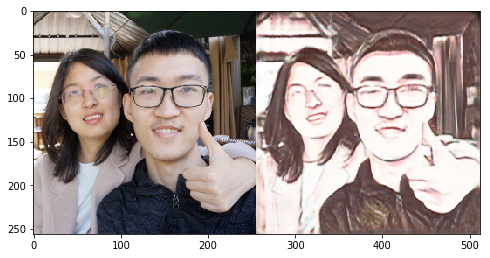

In [19]:
# 读取数据
OWN_TEST=True
# OWN_TEST=False
if OWN_TEST:
    datapath='work/test'#'data/cartoon_A2B/test'
else:
    datapath='data/cartoon_A2B/test'
test_names = os.listdir(datapath)
img_name = np.random.choice(test_names)
if OWN_TEST:
    img_A_r = cv2.imread(datapath+'/'+img_name)                       # 真人照
    # resize
    img_A =cv2.resize(img_A_r,dsize =(256,256),interpolation = cv2.INTER_CUBIC)
else:
    img_A2B = cv2.imread(datapath+'/'+img_name)
    img_A = img_A2B[:, :256]    
    img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()